## Computer Vision

### Module 4. Geometry and Augmented Reality

#### Task 4.4:
    1. Make 3 photos of the UCU building from different sides having >= 8 shared points
    2. Find fundamental matricies
    3. Build epipolar lines for all pairs of points


by Anastasiia Kasprova

    Link to Google Colab: https://colab.research.google.com/drive/1jYOjKESw-nG9Ko7OT7aQrGH0m_VhEEOc
    Link to github: https://github.com/kasprova/CV_UCU/tree/master/module4/tasks/task4

In [0]:
!ls data/epipolar_lines/

center_sheptytskogo1.jpg
center_sheptytskogo2.jpg
center_sheptytskogo3.jpg


In [0]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
#display an image
def display_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

#### 1. Implement 8-point algorithm

In [0]:
def from_pts_to_matrix(pts):
    """
    input: 2xN array
        [[x1,y1],[x2,y2],[x3,y3],...[xN,yN]]
    output: 3xN array
        |x1 x2 x3 ... xN|
        |y1 y2 y3 ... yN|
        | 1  1  1 ...  1|
        or in python representation
        [[x1,x2,x3,...,xN],
         [y1,y2,y3,...,yN],
         [ 1, 1, 1,..., 1]]
        
    """
    return np.append(pts.T, [np.ones(pts.shape[0])], axis=0)

def normalise2dpts(pts):
    #transform pts point into matrix representation
    pts_m = from_pts_to_matrix(pts1)

    #find centroids of x and y arrays
    centroid_x, centroid_y, _ = np.mean(pts_m, axis=1)

    #shift origin to centroid
    new_px = pts_m[:,0] - centroid_x
    new_py = pts_m[:,1] - centroid_y

    mean_distrib = np.mean(np.sqrt(new_px**2 + new_py**2))

    scale = np.sqrt(2)/mean_distrib

    T = np.array([[scale, 0, -scale*centroid_x],
         [0, scale, -scale*centroid_y],
         [0, 0, 1]], np.float32)
    pts_norm = np.dot(T,pts_m)
    
    return pts_norm, T

def find_fundamental_matrix(pts1,pts2):
    
    #perform normalization - translation and scaling
    pts1_norm, T1 = normalise2dpts(pts1)
    pts2_norm, T2 = normalise2dpts(pts2)
    
    A = np.array([
        pts2_norm[0]*pts1_norm[0], 
        pts2_norm[0]*pts1_norm[1],
        pts2_norm[0],
        pts2_norm[1]*pts1_norm[0],
        pts2_norm[1]*pts1_norm[1],
        pts2_norm[1],
        pts1_norm[0],
        pts1_norm[1],
        np.ones(pts1.shape[0])
    ], np.float32).T
    #since A*vec(F)=0 fundamental matrix F can be extacted from singular vector of V corresponding 
    #to smallest singular value - eigenvector
    #U,D,V = svd(A)::matlab
    U,D,V = np.linalg.svd(A)
    
    #F = reshape(V(:,9),3,3)::matlab
    F = V[-1].reshape(3,3) #corresponds to the smallest eigenvector
    
    #force F to be rank 2 matrix - lower rank approximation by svd
    #U,D,V = svd(F)::matlab
    U,D,V = np.linalg.svd(F)
    
    #F = U*diag([D(1,1) D(2,2) 0])*V::matlab
    F = np.dot(np.dot(U,np.diag([D[0],D[1],0])),V)

    #denormalize::matlab
    #F = T2*F*T1
    F = np.dot(np.dot(T2.T,F),T1)
    return F


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,3)
        img1 = cv2.circle(img1,tuple(pt1),5,color,20)
        img2 = cv2.circle(img2,tuple(pt2),5,color,20)
    return img1,img2


def find_epipolar_lines(pts, F):
    """
    input:  pts - points to compare
            F - fundamental matrix
    output: lines on another image we compare
    """
    lines = np.array((pts.shape[0], pts.shape[1]), np.float32)
    lines = [np.dot(F,np.array([p[0],p[1],1])) for p in pts]
    return lines

#### 2. Find fundamental matricies

In [0]:
img_folder = "data/epipolar_lines/"
img_list = os.listdir(img_folder)

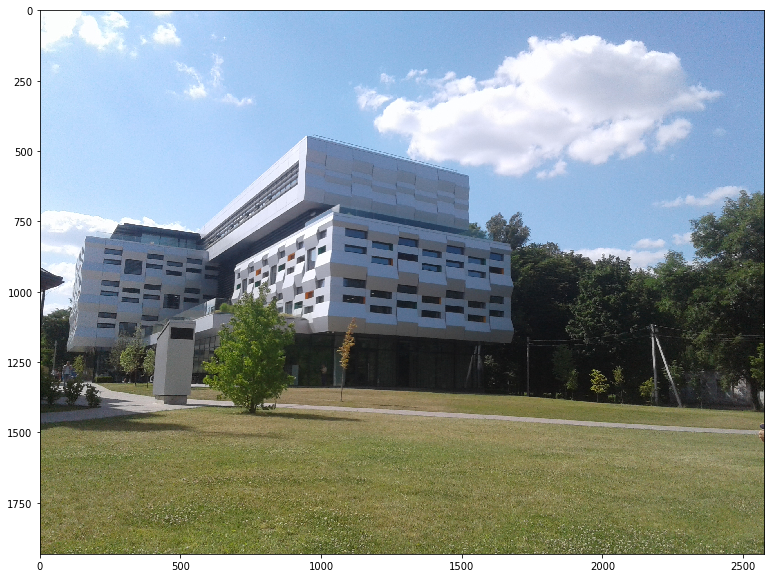

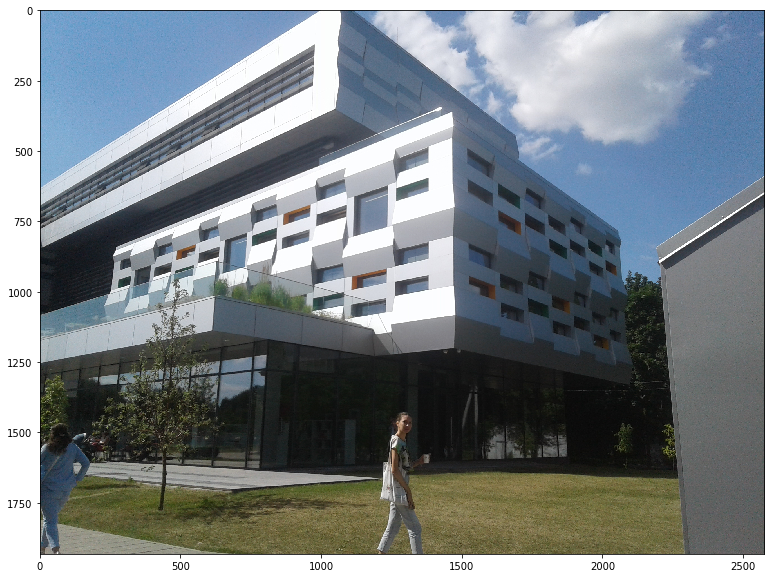

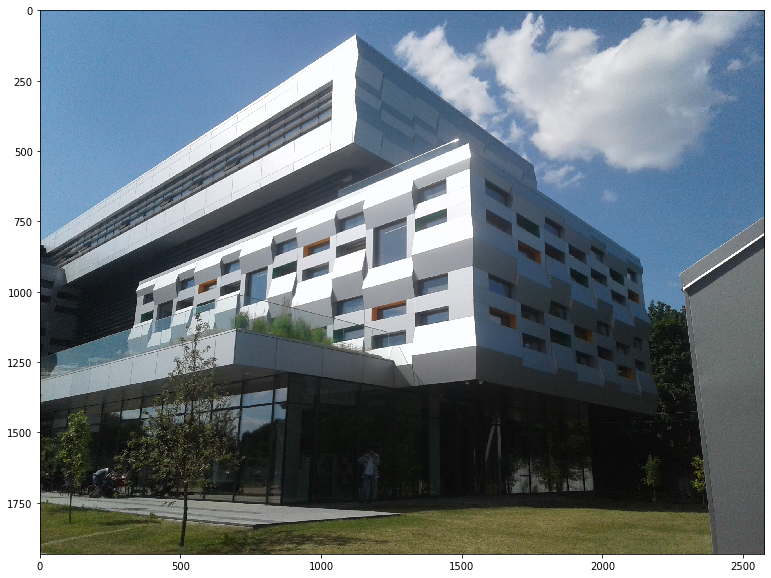

In [0]:
for i in img_list:
    img = cv2.imread(img_folder+i)
    display_image(img)

In [0]:
#manualy select points
#center_sheptytskogo1.jpg
pts1 = np.array([[950, 444],
                    [940, 670],
                    [1520,585],
                    [1046, 714],
                    [1670, 830],
                    [700, 900],
                    [605, 890],
                    [1028,1140]], np.int32)
#center_sheptytskogo2.jpg
pts3 = np.array([[1127, 85],
                    [1115, 470],
                    [1755,552],
                    [1525,470],
                    [2130, 880],
                    [350, 965],
                    [105, 965],
                    [1550,1315]], np.int32)

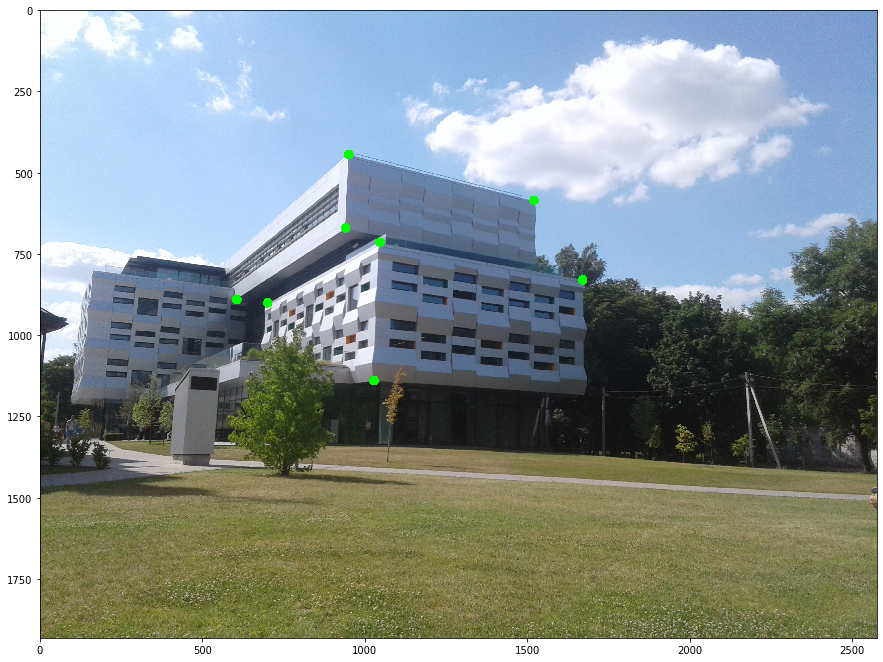

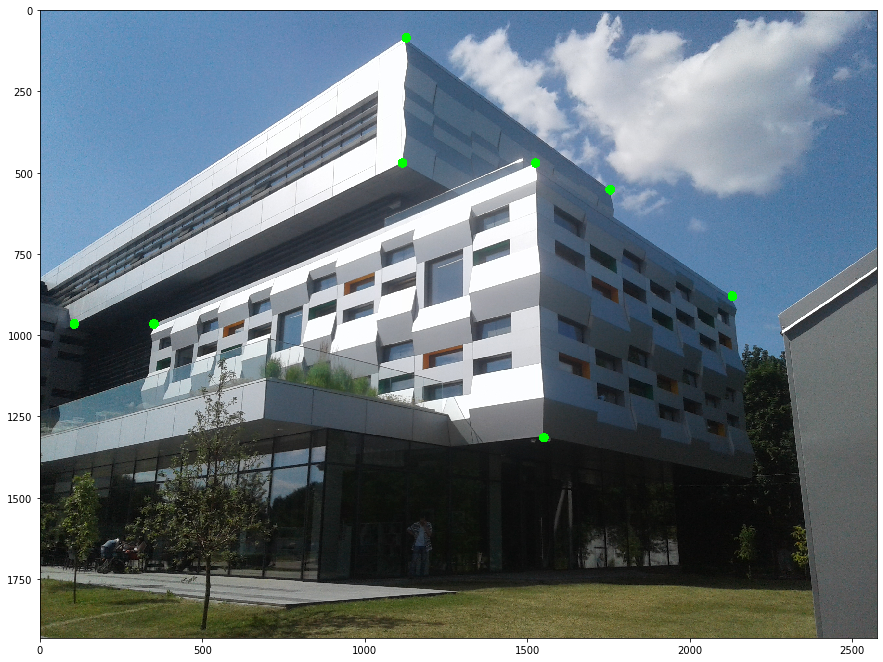

In [0]:
#display points on images
img1 = cv2.imread(img_folder+img_list[0]).copy()
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
for p in pts1:
    img1 = cv2.circle(img1, (p[0], p[1]), 5, (0,255,0), 20)
display_image(img1)

img3 = cv2.imread(img_folder+img_list[2]).copy()
img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
for p in pts3:
    img3 = cv2.circle(img3, (p[0], p[1]), 5, (0,255,0), 20)
display_image(img3)

In [0]:
#find fundamental matrix
F = find_fundamental_matrix(pts1,pts3)

#### 3. Build epipolarlines for all pairs of points

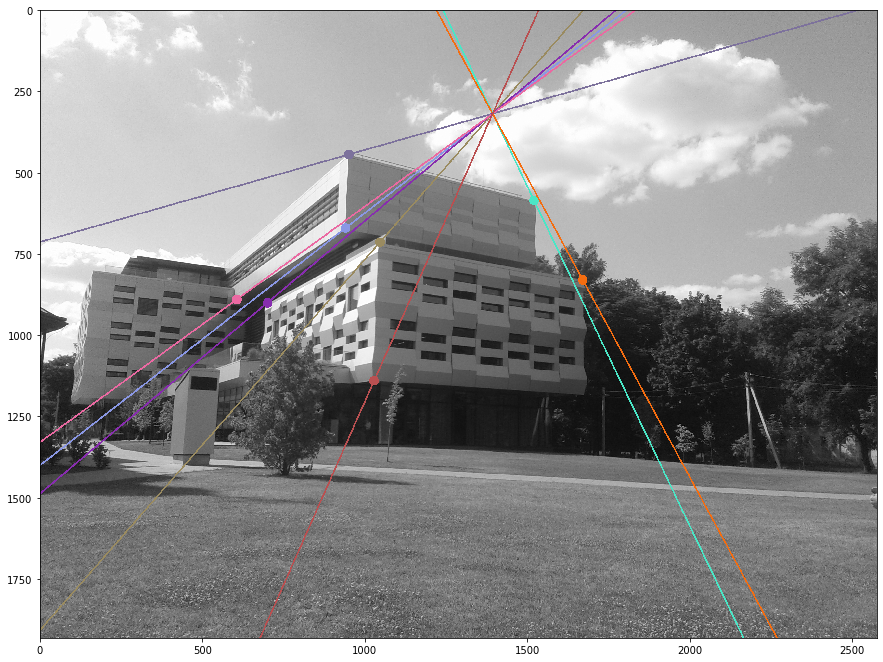

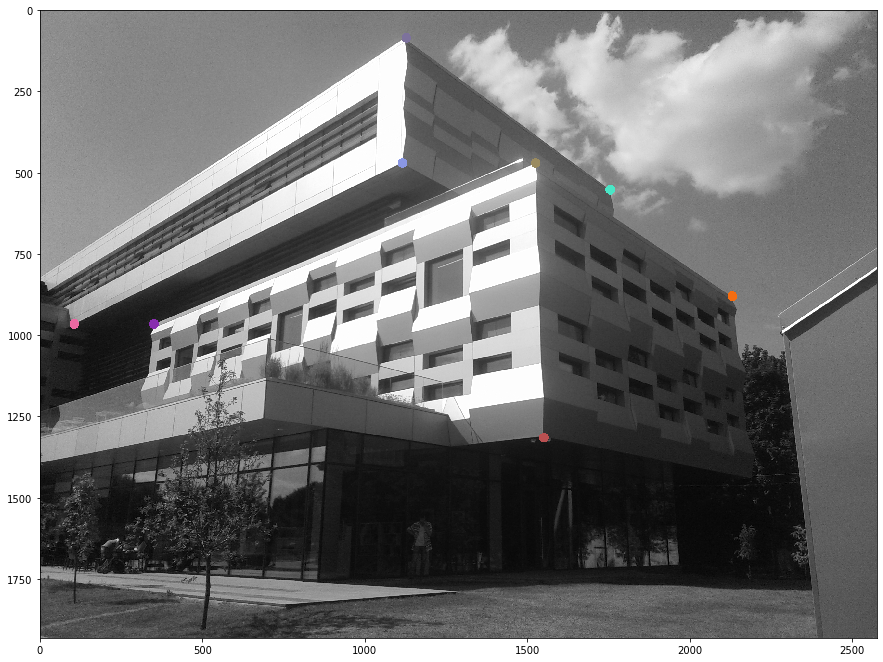

In [0]:
lines1 = find_epipolar_lines(pts1, F)
img1_, img3_ = drawlines(img1_gray, img3_gray, lines1, pts1, pts3)
plt.figure(1)
plt.imshow(img1_)
plt.figure(2)
plt.imshow(img3_)
plt.show()

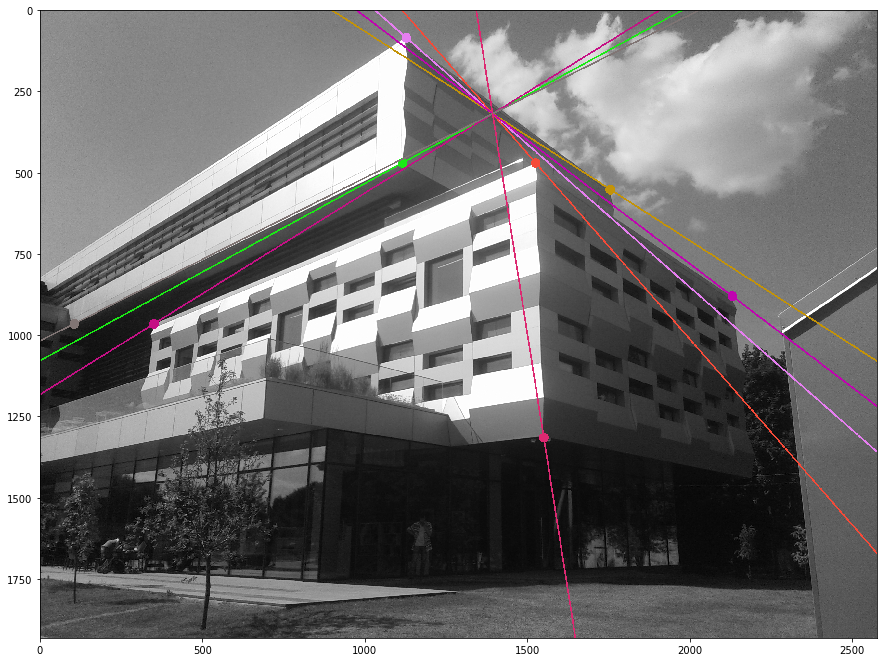

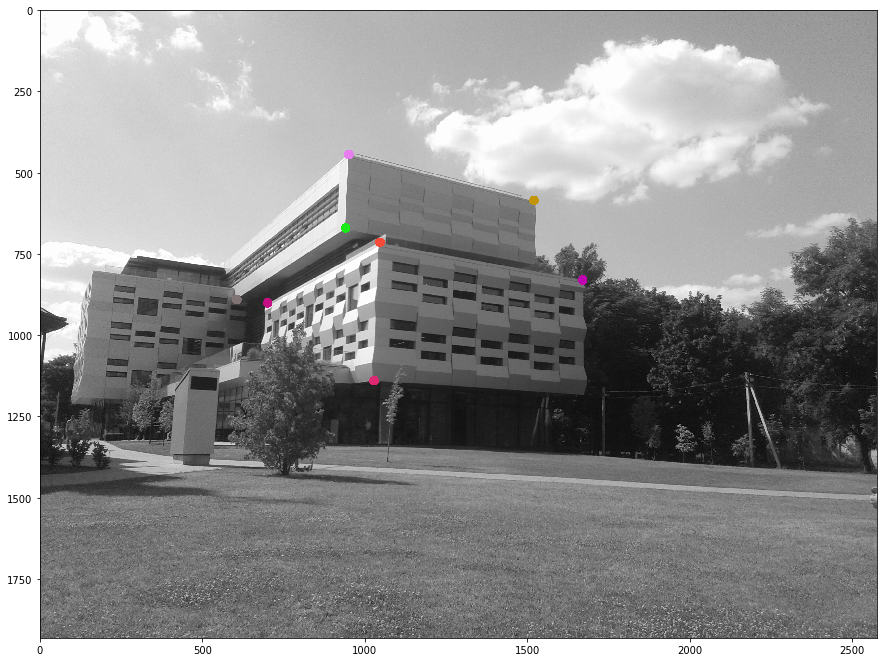

In [0]:
lines3 = find_epipolar_lines(pts3, F)
img1__, img3__ = drawlines(img3_gray, img1_gray, lines3, pts3, pts1)
plt.figure(1)
plt.imshow(img1__)
plt.figure(2)
plt.imshow(img3__)
plt.show()

#### References:
    1. https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
    2. https://github.com/PrimozGodec/machine-perception-ex5/blob/master/normalize2dpts.m
